# this one is still a work in progress

Feel free to look around, but it's not really ready, so bear with me

In [1]:
import pandas as pd 
% matplotlib inline 
from matplotlib import pyplot as plt 
import numpy as np

from sklearn.linear_model import LinearRegression # <-- We're only importing this to observe R2 on the chart 

import warnings # this is to suppress an annoying warning from sklearn 
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use('seaborn')

Let's get our dataset: 

In [2]:
train = pd.read_csv('../data/sales_data.csv', 
                    low_memory=False)  # this is used to ensure that it checks the types properly 

In [3]:
# this is a little util to get a fraction of the trainign set, to speed things up. 
# Because we want to keep the timeseries intact, we will use a percentage of stores, not a percentage of the data.  

def get_10_percent_of_stores(training_set):
    sample_of_stores = pd.Series(
        training_set.Store.unique()).sample(
        frac=.1, random_state=3000).values
    
    return training_set.loc[training_set.Store.isin(sample_of_stores)]

In [4]:
run_full_dataset = input('\nDo you want to run with the full dataset?'
                         '\nNote: y is only recommended if you have a huge machine with lots of cores\n'
                         '(y / n) <-- seriously, choose "n" \n\n')

if run_full_dataset != 'y':
    train = get_10_percent_of_stores(train)


Do you want to run with the full dataset?
Note: y is only recommended if you have a huge machine with lots of cores
(y / n) <-- seriously, choose "n" 

n


Prepare the index, to make it a timeseries: 

In [5]:
train['Date'] = pd.to_datetime(train['Date'],       # we want the Date column to be a date 
                               format='%Y-%m-%d')   # the date format helps Pandas not have to infer it 

train.set_index(['Date', 'Store'],     # A multi-index, as we care about both companies and dates
                inplace=True)          # Set the index in place 
train.sort_index(inplace=True)         # sort the dataset on the index 

Quick glance: 

In [6]:
train.head(5)

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2013-01-01 2              2      0          0     0      0            a   
           44             2      0          0     0      0            a   
           81             2      0          0     0      0            a   
           109            2      0          0     0      0            a   
           113            2      0          0     0      0            a   

                  SchoolHoliday  Next day is SchoolHoliday  \
Date       Store                                             
2013-01-01 2                  1                          1   
           44                 1                          1   
           81                 1                          1   
           109                1                          1   
           113                1                          1   

                 Next day is StateHoliday  Next day is a Promo  \
Date       Store                                                 
2013-01-01 2                            0                    0   
           44                           0                    0   
           81                           0                    0   
           109                          0                    0   
           113                          0                    0   

                  Next day is Open  
Date       Store                    
2013-01-01 2                     1  
           44                    1  
           81                    1  
           109                   1  
           113                   1

Notice that the index is both the Date and the Store.

### Creating the target variable

Unlike normal problems, the definition of the target variable here is something we need to define. 

We can't base ourselves on the number of clients that come through the door, because we don't know that the previous day. We can however know on the previous day whether the store will be open, and if will be a state holiday, etc. 

Let's say we want to predict the sales of store A on day D.   
We have a couple of options: 

1. Train on the whole history of store A, and predict day D based on the behavior of Store A on day D-1
2. Train on the whole history of every store, and predict day D based on the behavior of Store A on day D-1

Either way, we will be based on the behavior of Store A on the previous day. Therefore we are going to groupby Store, and then take the sales from the next day (using [shift](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html)) 

In [7]:
train['Next day sales'] = train.groupby(level='Store')['Sales'].shift(-1)

Let's observe a single store, to make sure this worked: 

In [8]:
train.xs(44,              # <-- the store number (I just chose one)
         level='Store',     # <-- The level of the index 
         drop_level=True    # <-- Whether we want to keep the store in the index (would just be 1115 over and over)
        )[['Sales', 'Next day sales']].head(7)           # <-- show the first 7 lines     

,Sales,Next day sales
Date,,
2013-01-01,0,4666.0
2013-01-02,4666,3853.0
2013-01-03,3853,4407.0
2013-01-04,4407,3652.0
2013-01-05,3652,0.0
2013-01-06,0,9818.0
2013-01-07,9818,6149.0


Great, so this will become our training set. What is the last day we have? 

In [9]:
last_day = train.index.get_level_values('Date').max()
print(last_day)

2015-05-29 00:00:00


But wait, if that's the last day, what is the "Next day sales" on that day? 

In [10]:
train.xs(last_day,                              # <-- the date
         level='Date',                          # <-- The level of the index 
         drop_level=True                        # <-- Whether we want to keep the store in the index (would just be 1115 over and over)
        )[['Sales', 'Next day sales']].head(7)  # <-- show the first 7 lines     

,Sales,Next day sales
Store,,
2,4541,NaN
44,5824,NaN
81,7482,NaN
109,7533,NaN
113,6185,NaN
125,14879,NaN
150,9127,NaN


Makes sense, on the last day, we don't actually know what the next day sales will be. We will in fact use this last day to predict the first day of the (as yet unseen) test set. 

So, for now, let's dropa that last day, call the target `'Next day sales'`, and get into the fun task of creating an actual model. 

In [11]:
train.dropna(inplace=True)

In [12]:
target = 'Next day sales'

In [13]:
train.head(3)

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2013-01-01 2              2      0          0     0      0            a   
           44             2      0          0     0      0            a   
           81             2      0          0     0      0            a   

                  SchoolHoliday  Next day is SchoolHoliday  \
Date       Store                                             
2013-01-01 2                  1                          1   
           44                 1                          1   
           81                 1                          1   

                 Next day is StateHoliday  Next day is a Promo  \
Date       Store                                                 
2013-01-01 2                            0                    0   
           44                           0                    0   
           81                           0                    0   

                  Next day is Open  Next day sales  
Date       Store                                    
2013-01-01 2                     1          4422.0  
           44                    1          4666.0  
           81                    1          7181.0

# How will we evaluate how well we predict the next day sales? 

Well, that requires establishign a way to evaluate ourselves. Let's try a few: 
1. [Mean squared error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) 
2. [Median absolute error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html) 
3. [R squared](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

Each of these has advantages and disadvantages: 
- Mean squared error (MSE) is a classic, but is really sensitive to  outliers. It also gives us a response which is in "squared errors", which isn't very intuitive. If we're off by 25$, knowing that our error is 625 doesn't really tell us much. 

- Mean absolute error (MAE) is a more robust metric, and has the advantage of being in the same order of magnitude as the values we are trying to predict. If we predict 1000 and the right answer was 950, then our MAE is 50, which is more satisfying. However the error on the largest values (predicting 1000 when it was 950) will be more important than on the smallest ones (predicting 100 when it was 95), so it is biased by the largest amounts. Depending on the business end, that might be a good thing (being wrong on smaller predictions might be less of a problem).  

- R squared (R2) has the main advantage of being between 0 and 1 (yay!), as it is the coefficient of determination of the regression between predicted and observed. In other words, if you fit a line between your predictions and reality, ideally it would be a perfect diagonal, and the less "perfect" it is, the lower your R2. Deeply satisfying! 

### Do the sales the previous day predict the sales the next day? 

Sounds obvious enough that a trivial way to make predictions is simply to repeat the sales of the previous day. 

So let's establish a baseline by doing just that! 

In [14]:
# Let's use R2 for the time being: 
from sklearn.metrics import r2_score

In [15]:
# just starting a dictionary to keep track of how we do: 
attempts = pd.Series()

In [16]:
attempts['Naively using the previous day'] = r2_score(y_true=train['Next day sales'],
         y_pred=train['Sales'])

attempts

Naively using the previous day   -0.420222
dtype: float64

Wait, what?? 

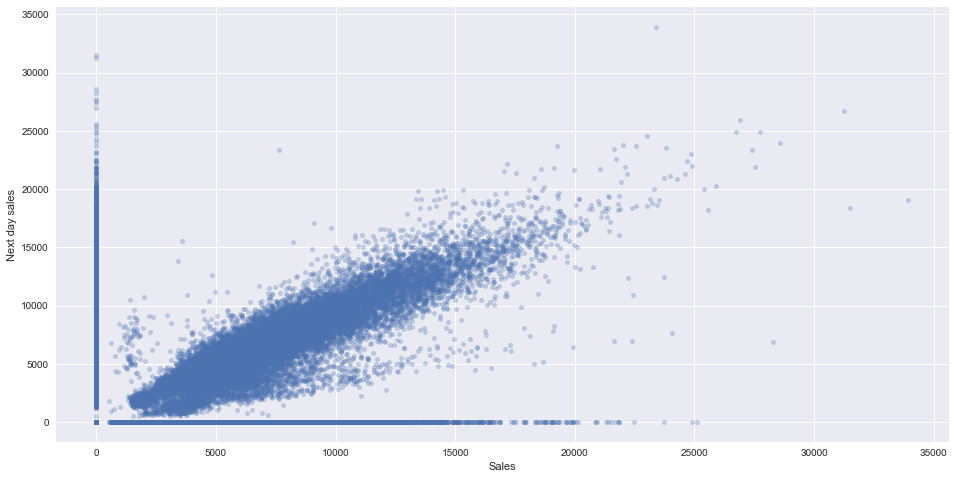

In [17]:
train.plot(kind='scatter', 
           x='Sales',
           y='Next day sales', 
           figsize=(16, 8), 
           alpha=.3)

Ooooh right, the days when nothing was sold. Out of curiosity, what's the best line to fit this? 

Let's be a smartass and make a function to show us our predictions graphically: 

In [18]:
def show_predictions(predictions, train=train, target='Next day sales', display_formula=True):
    linreg = LinearRegression()
    linreg.fit(X=train[predictions].values.reshape(-1, 1), 
               y=train[target])

    train.plot(kind='scatter', x=predictions, y=target, figsize=(16, 8), alpha=.3)

    plt.plot(train[predictions].values, 
             linreg.predict(train[predictions].values.reshape(-1, 1)), 
             color='k')
    if display_formula:
        plt.title('%s = %s x %0.2f + %0.2f' % (target, 
                                               predictions, 
                                               linreg.coef_[0], 
                                               linreg.intercept_), fontsize=14)

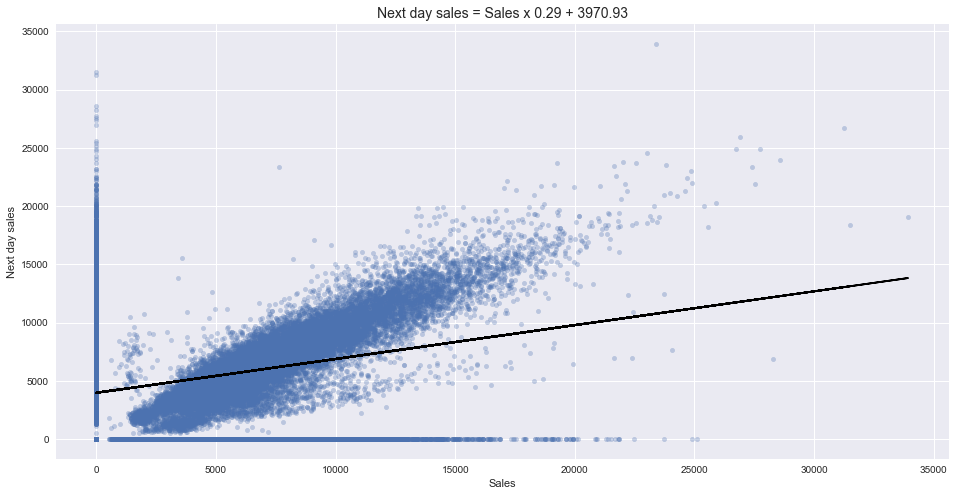

In [19]:
show_predictions('Sales', train=train, target='Next day sales')

Well, I think we can accept that's not a great prediction. 

Come to think of it, on Sundays and holidays there aren't any sales, maybe that's why we can't fit a line.

Let's take a look at a single store, during the first 14 days: 

In [20]:
def show_single_store_over_2_weeks(predictions, 
                                   target='Next day sales', 
                                   train=train, 
                                   store_nr=366):
    train.xs(store_nr, level='Store')[[predictions, target]].iloc[0:14].plot(kind='bar', 
                                                                  figsize=(16, 4),
                                                                 rot=45)
    plt.ylabel('Amount')
    plt.show()

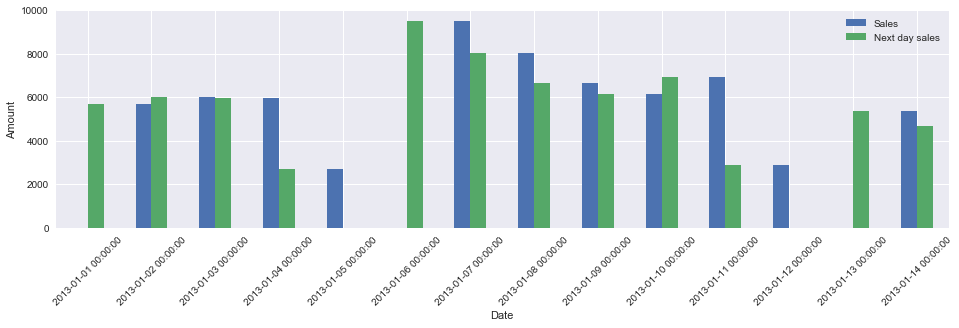

In [21]:
show_single_store_over_2_weeks('Sales')

Predictions aren't too terrible on some days, but it consistently messes up two days in a row, presumably 
- Sunday (where it says we sell the same as Saturday) 

and

- Monday (where it says we have no sales).

Let's calculate the R2 score per day of the week, using a groupby followed by an apply (serious stuff!) 

In [22]:
def show_r2_per_day(predictions, train=train, target='Next day sales'):
    
    r2_scores_per_day_of_week = train.groupby('DayOfWeek').apply(lambda x: r2_score(x[target] , 
                                                                                x[predictions]))

    # plot to make it more legible: 
    r2_scores_per_day_of_week.plot(kind='bar', rot=0, alpha=.5)
    plt.ylabel('R2 score')

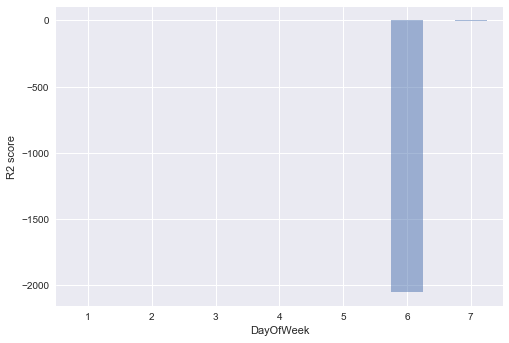

In [23]:
show_r2_per_day('Sales')

Ok, so we're terrible on day 6 and 7, makes sense. 

# Let's get a bit smarter... 

So using the previous day did not work. But how about using 7 days before? (the previous week's sale)  

Given that we can only use the day before, that means subtracting another 6 days. In plain English: _"in order to predict Friday, with information available on Thursday, I can look at what sales were made 6 days before that Thursday"_

In [24]:
train['Sales lagged by 6 days'] = train.groupby('Store')['Sales'].shift(6)

In [25]:
train.dropna(inplace=True) # <-- the previous step will have generated some more missing data

In [26]:
train.xs(366, level='Store')[['DayOfWeek', 
                              'Sales', 
                              'Sales lagged by 6 days']].head(10)

,DayOfWeek,Sales,Sales lagged by 6 days
Date,,,
2013-01-07,1,9506,0.0
2013-01-08,2,8036,5665.0
2013-01-09,3,6643,6009.0
2013-01-10,4,6158,5977.0
2013-01-11,5,6907,2708.0
2013-01-12,6,2887,0.0
2013-01-13,7,0,9506.0
2013-01-14,1,5364,8036.0
2013-01-15,2,4672,6643.0


In [27]:
attempts['Using the previous weeks sales'] = r2_score(train['Next day sales'], 
                                                      train['Sales lagged by 6 days'])


In [28]:
attempts

Naively using the previous day   -0.420222
Using the previous weeks sales    0.391396
dtype: float64

Ok, so we're in positive territory. 

Let's quickly make a small function to plot the results: 

In [29]:
def plot_results(res):
    res.sort_values(ascending=False).plot(
        kind='barh', figsize=(16, 4))
    plt.xlabel('R2')

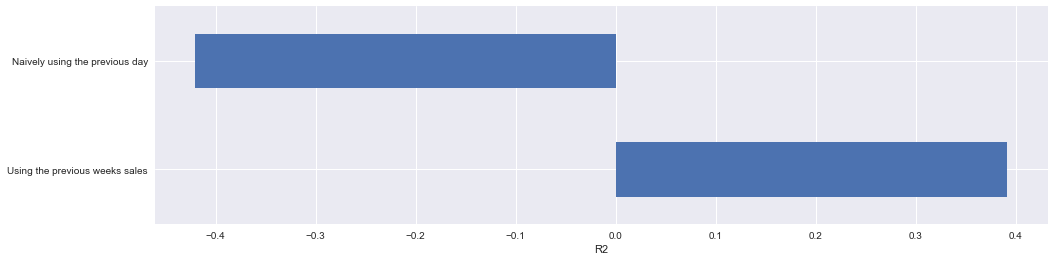

In [30]:
plot_results(attempts)

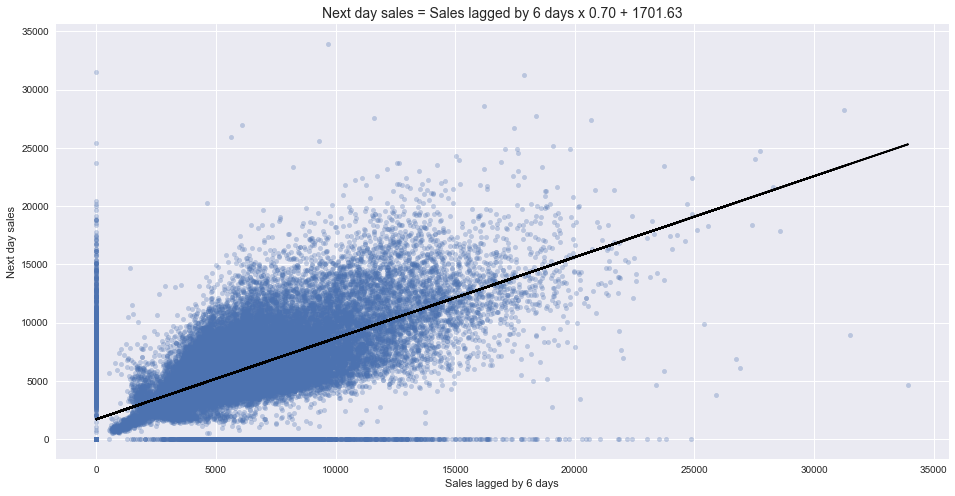

In [31]:
show_predictions('Sales lagged by 6 days')

Getting better, let's observe a single store: 

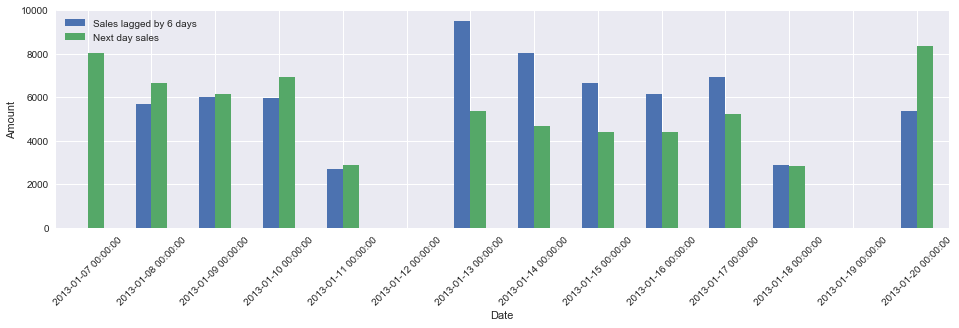

In [32]:
show_single_store_over_2_weeks('Sales lagged by 6 days')

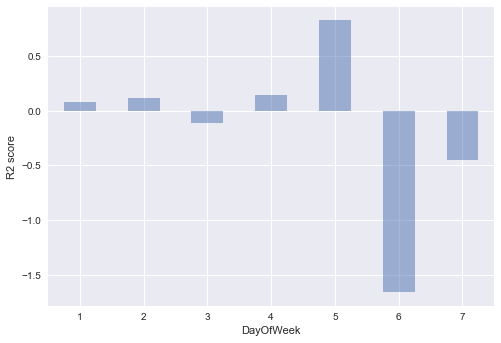

In [33]:
show_r2_per_day('Sales lagged by 6 days')

Not bad. It's just repeating the previous week, but the ability to capture weekends is much improved. 

What it still can't do is work with whether the store is open or not, particularly on Holidays. Let's fix that. 

### If the store is closed, we predict zero. Else, we predict the previous week's sales. 

To make this prediction, we'll have to be a bit smarter, and use [pandas apply](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) to use two columns simultaneously ([this SO answer](https://stackoverflow.com/questions/16353729/pandas-how-to-use-apply-function-to-multiple-columns) explains it well)

In [34]:
train['predictions'] = train.apply(lambda x: x['Sales lagged by 6 days'] 
                                   if x['Next day is Open'] != 0 else 0, 
                                   axis=1)

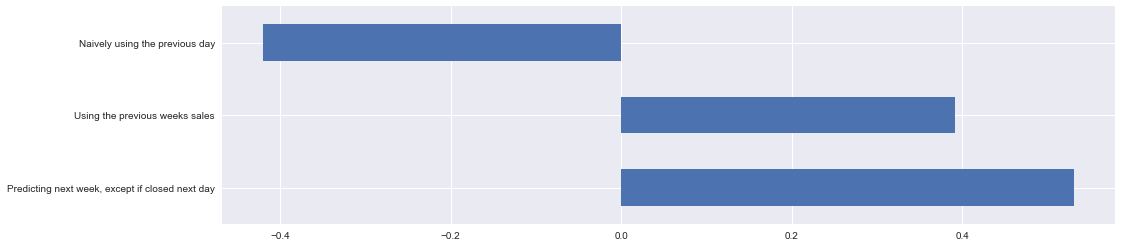

In [35]:
attempts['Predicting next week, except if closed next day'] = r2_score(train['Next day sales'], 
                                                      train['predictions'])

attempts.sort_values(ascending=False).plot(kind='barh', figsize=(16, 4))

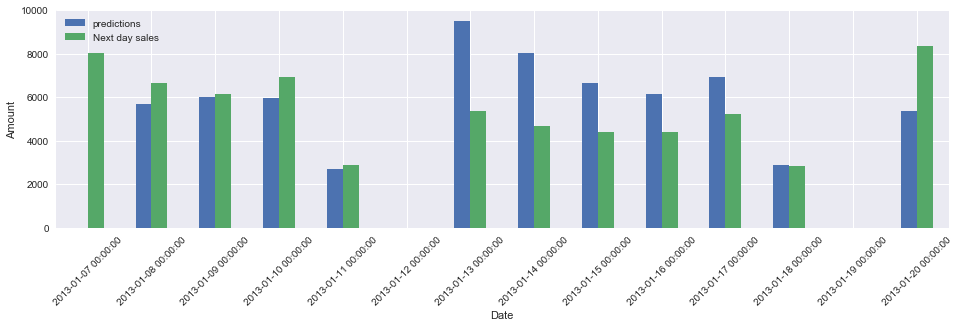

In [36]:
show_single_store_over_2_weeks('predictions')

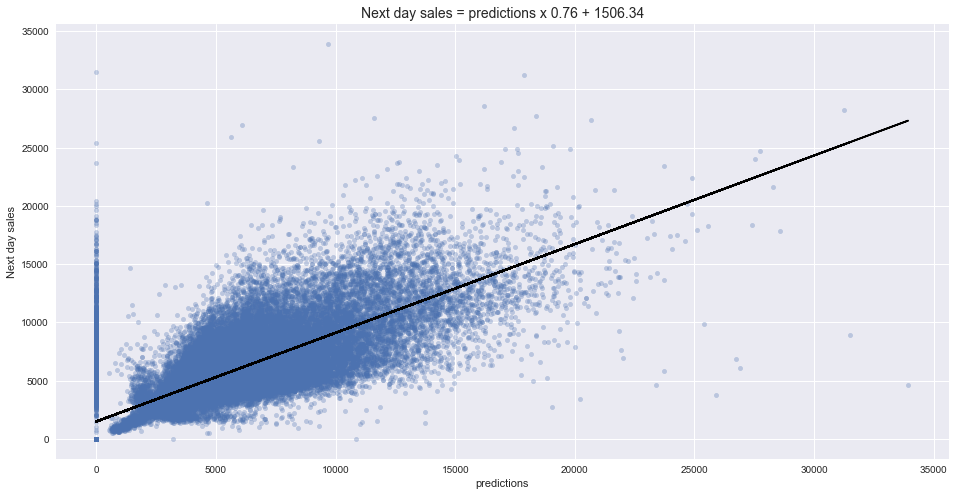

In [37]:
show_predictions('predictions')

That's unexpected, it seems to be predicting zero on days where it is selling. Those are probably the ones where the previous week was closed (maybe because of a holiday), tomorrow is open, but when I predict the last week... it's zero. 

Maybe we need to give it an indication at to whether last week was closed. 

In [38]:
train.head()

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2013-01-07 2              1   6775        763     1      1            0   
           44             1   9818        925     1      1            0   
           81             1   8546        647     1      1            0   
           109            1   8834        946     1      1            0   
           113            1  10343        898     1      1            0   

                  SchoolHoliday  Next day is SchoolHoliday  \
Date       Store                                             
2013-01-07 2                  0                          0   
           44                 0                          0   
           81                 0                          0   
           109                0                          0   
           113                0                          0   

                 Next day is StateHoliday  Next day is a Promo  \
Date       Store                                                 
2013-01-07 2                            0                    1   
           44                           0                    1   
           81                           0                    1   
           109                          0                    1   
           113                          0                    1   

                  Next day is Open  Next day sales  Sales lagged by 6 days  \
Date       Store                                                             
2013-01-07 2                     1          6318.0                     0.0   
           44                    1          6149.0                     0.0   
           81                    1          6574.0                     0.0   
           109                   1          7178.0                     0.0   
           113                   1          7671.0                     0.0   

                  predictions  
Date       Store               
2013-01-07 2              0.0  
           44             0.0  
           81             0.0  
           109            0.0  
           113            0.0

In [39]:
train['6 days ago was Open'] = train.groupby(level='Store').shift(6)['Open']

In [40]:
train.dropna(inplace=True)

Let's observe these instance where we predicted zero, and yet the next day was open: 

In [41]:
train.loc[(train['predictions'] == 0) & 
          (train['Next day is Open'] == 1)
         ].head()[['Open', 
                   '6 days ago was Open',
                   'Next day is Open',
                   'Sales lagged by 6 days',
                   'predictions',  
                   'Next day sales']]

Open  6 days ago was Open  Next day is Open  \
Date       Store                                                
2013-02-17 885       0                  0.0                 1   
2013-03-30 433       1                  0.0                 1   
2013-04-04 2         1                  0.0                 1   
           44        1                  0.0                 1   
           81        1                  0.0                 1   

                  Sales lagged by 6 days  predictions  Next day sales  
Date       Store                                                       
2013-02-17 885                       0.0          0.0          6357.0  
2013-03-30 433                       0.0          0.0           995.0  
2013-04-04 2                         0.0          0.0          3872.0  
           44                        0.0          0.0          4868.0  
           81                        0.0          0.0          5760.0

Aha! 

In [42]:
train.loc[(train['predictions'] == 0) & 
          (train['Next day is Open'] == 1)]['6 days ago was Open'].value_counts()

0.0    1311
1.0       6
Name: 6 days ago was Open, dtype: int64

So our theory works almost always, with a very small number of exceptions. Let's add this to our predictions. 

### So we're going to try... 

- If the store is closed the next day, we predict zero. 
- Else, if 6 days ago it was open, we predict the previous week's sales. 
- If it is open the next day, but it was closed last week, we predict with today's sales (we know the limitations of this) 

Bring in the apply method! 

In [43]:
def predict_sales(prev_day):
    if prev_day['Next day is Open'] == 0: 
        return 0
    elif prev_day['6 days ago was Open'] != 0:
        return prev_day['Sales lagged by 6 days']
    else: 
        return prev_day['Sales']

Warning: this might take a while, because it has a bunch of checks to perform for each row:

In [44]:
%%time 
train['predictions'] = train.apply(predict_sales, axis=1)

CPU times: user 6.81 s, sys: 147 ms, total: 6.96 s
Wall time: 7.86 s


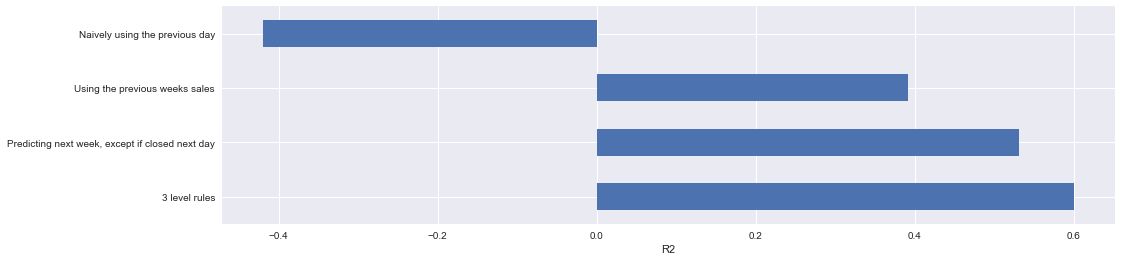

In [45]:
attempts['3 level rules'] = r2_score(train['Next day sales'], 
                                                      train['predictions'])

plot_results(attempts)

Alright, let's give scikit a chance, knowing where our baseline is! 

# Using ML regressors

Before we jump in, a bit of a sanity check: 

**<font color='red'> We are committing the #1 crime in machine learning: testing on the traning set </font>** 

The reason for this is simply that we are trying to gain an intuition for the data. Later we will obviously have to switch to cross validation. 

In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import graphviz

Let's start by building a decision tree using scikit, and giving it different depths. 

For instance, we've built a 3 level decision tree by hand, using the following: 

- '6 days ago was Open',
- 'Next day is Open',
- 'Sales lagged by 6 days',

What would scikit do with these features? 

In [47]:
features = [
    '6 days ago was Open',
    'Next day is Open',
    'Sales lagged by 6 days',
    'Sales']

target = 'Next day sales'

In [48]:
tr = DecisionTreeRegressor(max_depth=2)
tr.fit(train[features], train[target])

train['predictions'] = tr.predict(train[features])

attempts['scikit 2 level tree'] = r2_score(train['Next day sales'], 
                                     train['predictions'])

print(attempts)

Naively using the previous day                    -0.420222
Using the previous weeks sales                     0.391396
Predicting next week, except if closed next day    0.531174
3 level rules                                      0.600567
scikit 2 level tree                                0.604869
dtype: float64


Let's see how scikit got to this result... 

Note: [Graphviz](https://pypi.python.org/pypi/graphviz) is awesome for visualizing trees and understanding what you are doing. It is optional, but recommended. 

Install: `pip install graphviz`

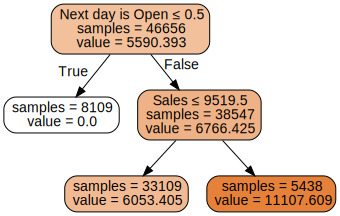

In [49]:
dot_data = tree.export_graphviz(tr, out_file=None, 
                         feature_names=features,  
                         filled=True, 
                         impurity=False,
                         rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)
graph 

Hmn, so it is actually only predicting 3 values. What does the plot look like?

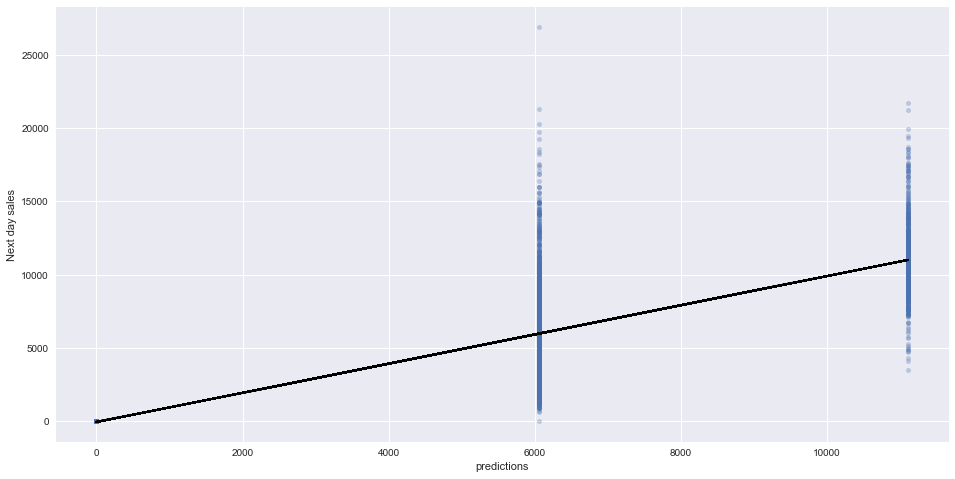

In [50]:
show_predictions('predictions', train=train.sample(frac=.1), display_formula=False)

Let's give it more depth then. 

In [51]:
tr = DecisionTreeRegressor(max_depth=3)
tr.fit(train[features], train[target])

train['predictions'] = tr.predict(train[features])

attempts['scikit 3 level tree'] = r2_score(train['Next day sales'], 
                                     train['predictions'])

print(attempts)

Naively using the previous day                    -0.420222
Using the previous weeks sales                     0.391396
Predicting next week, except if closed next day    0.531174
3 level rules                                      0.600567
scikit 2 level tree                                0.604869
scikit 3 level tree                                0.681544
dtype: float64


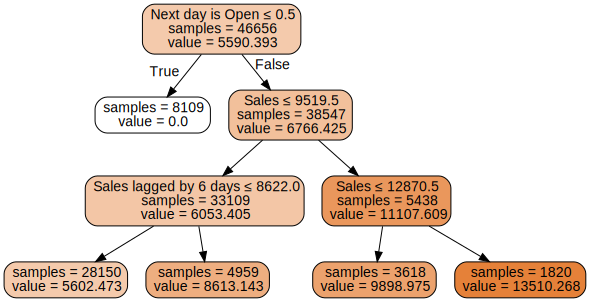

In [52]:
dot_data = tree.export_graphviz(tr, out_file=None, 
                         feature_names=features,  
                         filled=True, 
                         impurity=False,
                         rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)
graph 

Well, part of me is starting to think this tree can just remember the dataset better. 

How well can this thing do on cross validation? 

Evaluating: 

In [53]:
from sklearn.model_selection import cross_val_score 

In [54]:
def evaluate(estimator, X=train[features], y=train[target], scoring='r2'):
    return cross_val_score(estimator, 
                    X, 
                    y, 
                    scoring=scoring, 
                    cv=None, 
                    n_jobs=-1).mean()

In [55]:
evaluate(DecisionTreeRegressor(max_depth=3), 
         X=train[features], 
         y=train[target])

0.67457542541985438

Actually no, same performance! What if we go deeper? 

In [56]:
evaluate(DecisionTreeRegressor(max_depth=4), 
         X=train[features], 
         y=train[target])

0.73079046830969008

Wow! 

In [57]:
decision_tree = DecisionTreeRegressor(max_depth=4)

In [58]:
decision_tree.fit(train[features], train[target])

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

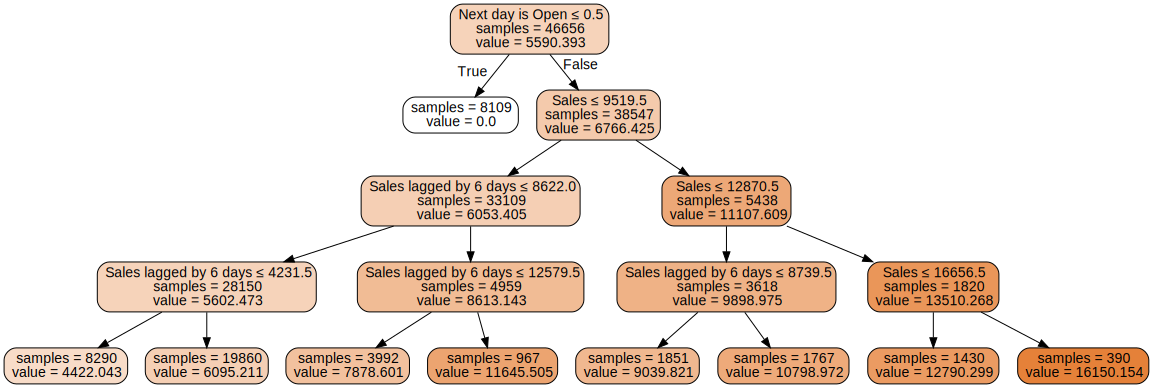

In [59]:
dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                         feature_names=features,  
                         filled=True, 
                         impurity=False,
                         rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)
graph 

Alright, let's see how deep we should go with this. 

protip: If you like progress bars, you'll like [tqdm](https://pypi.python.org/pypi/tqdm#installation)  
install: `pip install tqdm`

In [60]:
from tqdm import tqdm  # <-- optional, just makes a progress bar

# TODO: turn this back on

In [61]:
%%time 
cv_scores = {}
for i in tqdm(range(1, 30)):  #  <-- if you aren't using tqdm, simply remove the tqdm bit on this line 
    cv_scores[i] = evaluate(DecisionTreeRegressor(max_depth=i), 
         X=train[features],
         y=train[target])

100%|██████████| 29/29 [00:09<00:00,  2.74it/s]

CPU times: user 2.59 s, sys: 1.63 s, total: 4.22 s
Wall time: 9.69 s


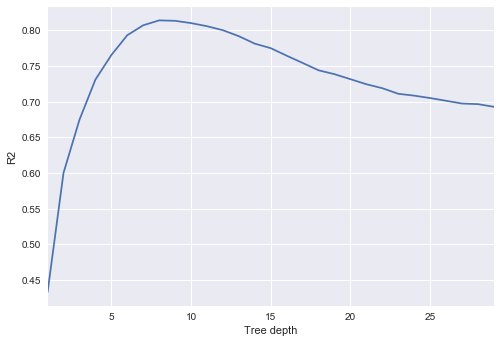

In [62]:
trees = pd.Series(cv_scores)
trees.plot(label='Tree regressors')
plt.xlabel('Tree depth')
plt.ylabel('R2')
plt.show()

In [63]:
trees.max()

0.81378504503988758

Awesome, and we can actually see where it starts to overfit: 

In [64]:
trees.argmax()

8

To be able to see how these predictions would work out on the training set without testing on the training set, we can use the awesome [cross_val_predict](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) _(note: this is proper advanced, so think as it as useful, but optional)_

In [65]:
from sklearn.model_selection import cross_val_predict

In [66]:
train['predictions'] = cross_val_predict(DecisionTreeRegressor(max_depth=9), 
                  train[features], 
                  train[target])

Plotting things is becoming increasingly hard, but we can try: 

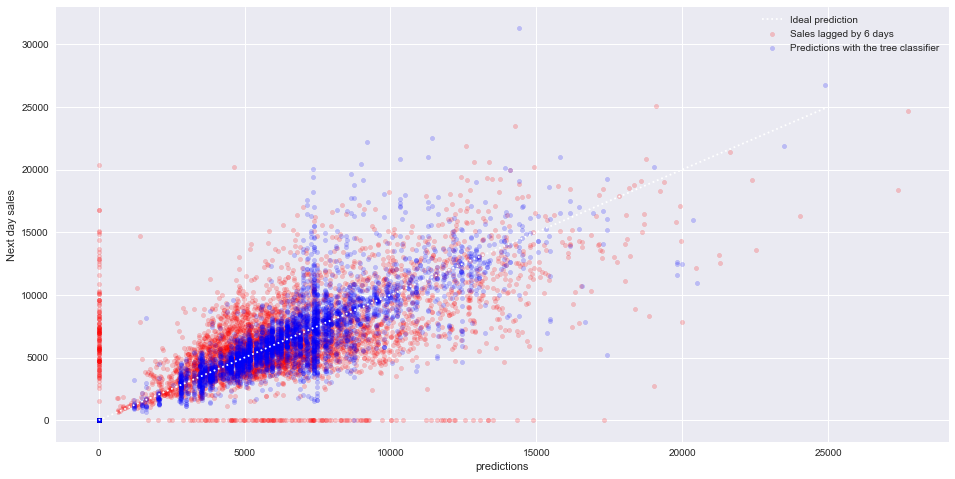

In [67]:
ax1 = train.sample(frac=.1).plot(kind='scatter',
                                 x='Sales lagged by 6 days',
                                 y=target, 
                                 figsize=(16, 8), 
                                 alpha=.2, 
                                 color='r',
                                label='Sales lagged by 6 days')

train.sample(frac=.1).plot(kind='scatter', 
                           x='predictions', 
                           y=target, 
                           ax=ax1, 
                           color='b', 
                           alpha=.2, 
                          label='Predictions with the tree classifier')

x = np.linspace(0, train['predictions'].max(), 100)
plt.plot(x,x,'w:', label='Ideal prediction') # identity line

plt.legend()

# Adding in more features

Great! Now, we were restricting these trees to only a few of our features, can they do better if we give them the rest? 

In [68]:
features = [
    '6 days ago was Open',
    'Customers',
    'DayOfWeek',
    'Next day is Open',
    'Next day is SchoolHoliday',
    #'Next day is StateHoliday',   # <-- rejected for now as it is categorical. Can use get_dummies later
    'Next day is a Promo',
    #'Next day sales',             # <-- that's the target
    'Open',
    'Promo',
    'Sales',
    'Sales lagged by 6 days',
    'SchoolHoliday',
    #'StateHoliday',               # <-- also categorical
    #'Store',                      # <-- categorical, so for now we'll avoid it
    #'predictions'                 # <-- wooooow, meta! 
]

In [69]:
%%time 
cv_scores = {}
for i in tqdm(range(1, 30)):  #  <-- if you aren't using tqdm, simply remove the tqdm bit on this line 
    cv_scores[i] = evaluate(DecisionTreeRegressor(max_depth=i), 
         X=train[features],
         y=train[target])

100%|██████████| 29/29 [00:11<00:00,  2.22it/s]

CPU times: user 3.29 s, sys: 1.61 s, total: 4.9 s
Wall time: 11.8 s


In [70]:
trees_with_all_features = pd.Series(cv_scores)

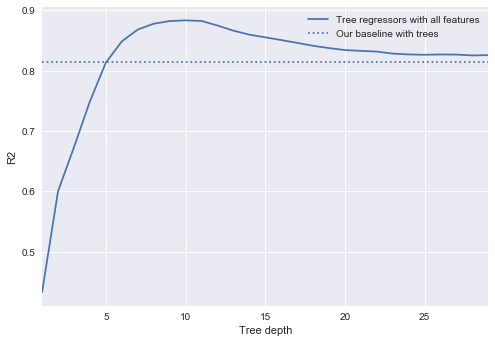

In [71]:
trees_with_all_features.plot(label='Tree regressors with all features')
plt.xlabel('Tree depth')
plt.ylabel('R2')
plt.axhline(trees.max(), ls=':', label='Our baseline with trees')
plt.legend()
plt.show()

Big wins! 

Alright, I know you're all thinking how well the Random forest will perform, so let's see. 

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
%%time 

mini_train = train.sample(frac=.1)  # <-- this operation will be very heavy, so running with sample first
cv_scores = {}
for i in tqdm(range(2, 30, 4)):  #  <-- if you aren't using tqdm, simply remove the tqdm bit on this line 
    cv_scores[i] = evaluate(RandomForestRegressor(n_estimators=100, max_depth=i, n_jobs=-1), 
         X=mini_train[features],
         y=mini_train[target])

100%|██████████| 7/7 [00:09<00:00,  1.41s/it]

CPU times: user 570 ms, sys: 278 ms, total: 848 ms
Wall time: 9.14 s


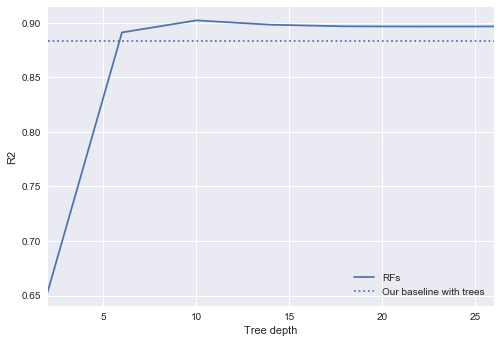

In [74]:
random_forests = pd.Series(cv_scores)
random_forests.plot(label='RFs')
plt.xlabel('Tree depth')
plt.ylabel('R2')
plt.axhline(trees_with_all_features.max(), ls=':', label='Our baseline with trees')
plt.legend()
plt.show()

Seems promising, let's try running a few with the full dataset, in that promising region 

In [75]:
start = 9 
end = 15
for i in tqdm(range(start, end, 1)):  #  <-- if you aren't using tqdm, simply remove the tqdm bit on this line 
    cv_scores[i] = evaluate(RandomForestRegressor(n_estimators=100, max_depth=i, n_jobs=-1), 
         X=train[features],  # <-- full dataset, you're machine had better be cooled down! 
         y=train[target])

100%|██████████| 6/6 [00:47<00:00,  8.18s/it]


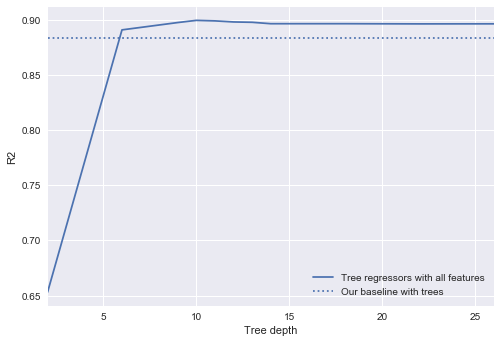

In [76]:
random_forests = pd.Series(cv_scores)
random_forests.plot(label='Tree regressors with all features')
plt.xlabel('Tree depth')
plt.ylabel('R2')
plt.axhline(trees_with_all_features.max(), ls=':', label='Our baseline with trees')
plt.legend()
plt.show()

In [77]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)

# Building more features

This is all great, but maybe we can so better. 

In [78]:
train['month'] = train.index.get_level_values('Date').month

In [79]:
features.append('month')

In [80]:
evaluate(RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1), 
         X=train[features],
         y=train[target])

0.90166429065571929

What was our previous best? 

In [81]:
random_forests.max()

0.89959864442324322

Pretty much the same. What are the features the Random Forest is using?

In [82]:
model.fit(train[features], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

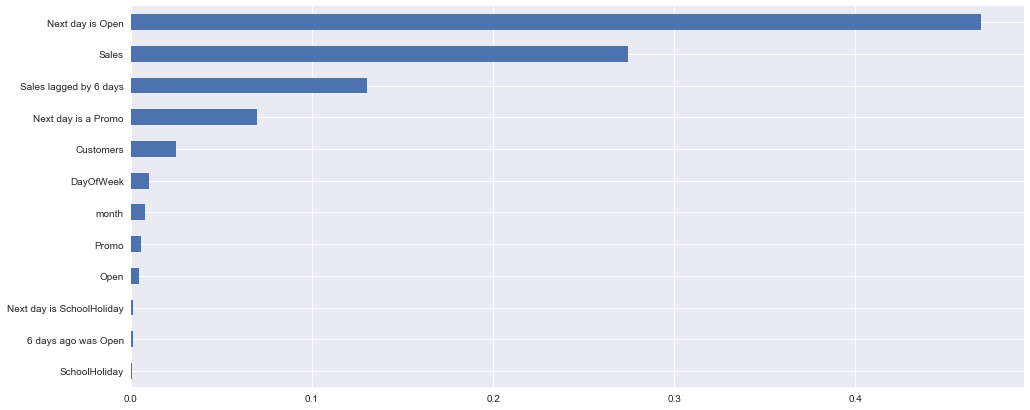

In [83]:
importances = pd.Series(dict(zip(features, model.feature_importances_)))
importances.sort_values().plot(kind='barh', figsize=(16, 7))
plt.show()

# Let's build another clever feature then... 

What other clever features can we build? Well, we might want to know if this is being a "good week", as compared to the previous week. 

One way to do this would be to compare the day before's sales with the same weekday on the previous week. Maybe there is some information in the fact that "_this Tuesday is better than the previous Tuesday_"?

In [84]:
train['Sales 7 days ago'] = train.groupby('Store').shift(7)['Sales']

As usual, this lost us a few days at the start of dataset, so we'll drop them   
_(pro-tip: generating all the features and dropping all the data at the end helps minimize this problem)._

In [85]:
train.dropna(inplace=True)

In [86]:
train['Ratio between weeks'] = train['Sales'] / train['Sales 7 days ago']

In [87]:
features.append('Ratio between weeks')

Was that useful? 

Things are about to go really, really wrong. 

In [88]:
try: 
    print(evaluate(model, 
                    X=train[features],
                    y=train[target])) 
    
except Exception as e:
    print('Everything failed catastrophically, and the error is this:\n')
    print(e.args[-1].split('\n')[-1])  #  <-- capturing the error and printing the last line. 

Everything failed catastrophically, and the error is this:

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


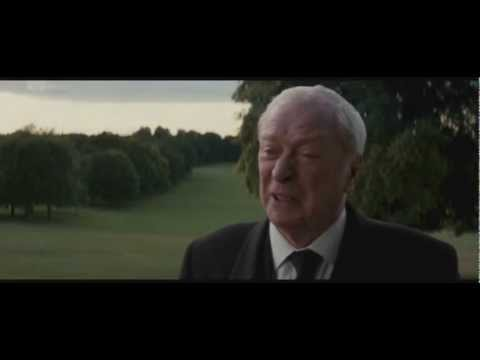

In [89]:
from IPython.display import YouTubeVideo
YouTubeVideo("BsBK3gyMFcw", autoplay=0)

What the hell went wrong? 

In [90]:
train.xs(366, level='Store').head(10)[['DayOfWeek', 
                                    'Open', 'Sales', 'Sales 7 days ago',
                                    'Ratio between weeks']]

,DayOfWeek,Open,Sales,Sales 7 days ago,Ratio between weeks
Date,,,,,
2013-01-20,7,0,0,0.0,NaN
2013-01-21,1,1,8333,5364.0,1.553505
2013-01-22,2,1,7442,4672.0,1.592894
2013-01-23,3,1,5899,4395.0,1.342207
2013-01-24,4,1,5966,4389.0,1.359307
2013-01-25,5,1,6208,5216.0,1.190184
2013-01-26,6,1,2334,2847.0,0.819810
2013-01-27,7,0,0,0.0,NaN
2013-01-28,1,1,4449,8333.0,0.533901


Ah, so when it's Sunday, we have a problem... We don't want to drop Sundays, but we also don't want to generate all those np.Nans.

If you think about it... those were divisions by zero. Nooooo! 

Let's build this feature again, and overwrite the previous attempt:

In [91]:
def ratio_if_not_zero_else_zero(row):
    if row['Sales 7 days ago'] == 0:
        return 0
    else: 
        return (row['Sales'] - row['Sales 7 days ago']) / row['Sales 7 days ago'] 

In [92]:
train['Ratio between weeks'] = train.apply(ratio_if_not_zero_else_zero, axis=1)

In [93]:
train.xs(366, level='Store').head(10)[['DayOfWeek', 'Open', 
                                       'Sales', 'Sales 7 days ago',
                                    'Ratio between weeks']]

,DayOfWeek,Open,Sales,Sales 7 days ago,Ratio between weeks
Date,,,,,
2013-01-20,7,0,0,0.0,0.000000
2013-01-21,1,1,8333,5364.0,0.553505
2013-01-22,2,1,7442,4672.0,0.592894
2013-01-23,3,1,5899,4395.0,0.342207
2013-01-24,4,1,5966,4389.0,0.359307
2013-01-25,5,1,6208,5216.0,0.190184
2013-01-26,6,1,2334,2847.0,-0.180190
2013-01-27,7,0,0,0.0,0.000000
2013-01-28,1,1,4449,8333.0,-0.466099


Solved it! 

In [94]:
try: 
    print(evaluate(model, 
                    X=train[features],
                    y=train[target])) 
    
except Exception as e:
    print('Everything failed catastrophically, and the error is this:\n')
    print(e.args[-1].split('\n')[-1])  #  <-- capturing the error and printing the last line. 

0.903968192393


In [95]:
model.fit(X=train[features],
                    y=train[target]);

In [102]:
cross_val_predict??

In [104]:
train['predictions'] = cross_val_predict(model, train[features], train[target])

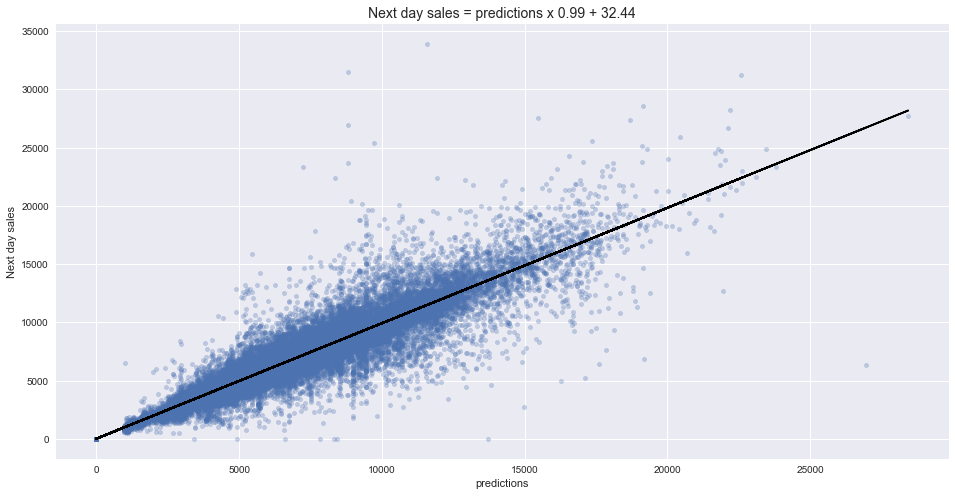

In [105]:
show_predictions('predictions', train=train, target='Next day sales')

# Putting it all together

This is all very interesting, but let's sake the following scenario:

* It's now May 1st, 2015 
* We are asked to predict May 2nd. 

In [98]:
unseen_data = pd.read_csv('../data/sales_data_recent.csv', low_memory=False)

In [99]:
unseen_data.head(2)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Next day is SchoolHoliday,Next day is StateHoliday,Next day is a Promo,Next day is Open
0,2015-05-30,369,6,7906,633,1,0,0,0,0,0,0,0
1,2015-05-30,370,6,9146,718,1,0,0,0,0,0,0,0


Unfortunately, this will not work: 

In [100]:
try: 
    model.predict(unseen_data[features])
except Exception as e: 
    print(e)

"['6 days ago was Open' 'Sales lagged by 6 days' 'month'\n 'Ratio between weeks'] not in index"


Oh, right. We don't have any of the features, or any of the work we've done so far, because it's a new dataset.

We don't even have the index done right in the new datset. Damn. 

So what we need is a function that can go through the new data, prepare it, and then make predictions. 

# Let's start again, and do things properly this time. 